# Importing required libraries

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline 
sns.set(color_codes=True)

# Read and format data

In [2]:
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.drop(['Volume_(BTC)', 'Volume_(Currency)'], axis=1, inplace=True)

,Timestamp,Open,High,Low,Close,Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN


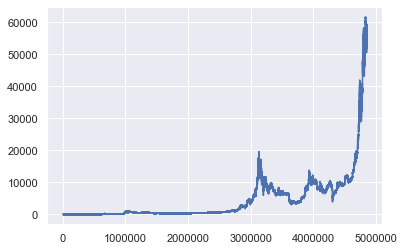

In [3]:
x = df['Timestamp']
y = df['Weighted_Price']

plt.plot(y)
df.head()
#df.tail()

# Important Constants

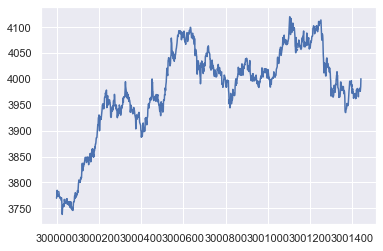

In [4]:
minutes_in_day = 24*60

# example day
lower = 3 * 10**6
upper = lower + minutes_in_day
day = df.loc[lower:upper]
prices = day['Weighted_Price']

plt.plot(prices)

# Helper functions for trading, calculations, visualization

In [35]:
#moving average, most useful in up/down trends over side-to-side

def calc_sd(rank, time_delta, current_index):
    sd = df['Weighted_Price'][current_index-rank*time_delta:current_index].std()
    nan_offset = rank - df['Weighted_Price'][current_index-rank*time_delta:current_index].count()
    return (sd, nan_offset)

def calc_mov_avg(rank, time_delta, current_index):
    average = df['Weighted_Price'][current_index-rank*time_delta:current_index].mean()
    nan_offset = rank - df['Weighted_Price'][current_index-rank*time_delta:current_index].count()
    return (average, nan_offset)

def efficient_mov_avg(prev_avg, rank, time_delta, index, nan_offset):
    old_value = df['Weighted_Price'].iloc[index-time_delta*rank-1]
    new_value = df['Weighted_Price'].iloc[index-1]
    
    old_is_nan = np.isnan(old_value)
    new_is_nan = np.isnan(new_value)
    
    old_divisor = rank-nan_offset # accounting for prev NaN's
    
    if old_is_nan:
        old_value = 0;
        nan_offset-=1
        
    if new_is_nan:
        new_value = 0
        nan_offset+=1
        
    new_divisor = rank - nan_offset # accounting for new NaN's
    
    if new_divisor == 0: # in the event all prev values are NaN
        avg = 0
        
    else:
        avg = (prev_avg * old_divisor - old_value + new_value)/new_divisor
    
    return (avg,nan_offset)

# trade/buy

def get_curr_price(index):
    return df['Weighted_Price'].iloc[index]

def execute_buy(curr_price, cash, coin, prop):
    if cash <= 0:
        return (cash,coin, False)
    coin += cash*prop / curr_price
    cash -= cash*prop
    return (cash,coin, True)

def execute_sell(curr_price, cash, coin, prop):
    if coin <= 0:
        return (cash,coin, False)
    cash += coin*prop * curr_price
    coin -= coin*prop
    return (cash,coin, True)

# analysis

def list_assets(start_cash, cash, coin, end_index, output = True):
    end_value = get_curr_price(end_index)
    total = (end_value * coin + cash)
    delta = ( ((total-start_cash)/start_cash)*100)
    
    if output:
        print("cash: %s" % cash) 
        print("coin: %s " % coin)
        print("total value: %s" % total)
        print("percent change: %s \n" % delta )
        
    return delta
    
def display_data(overall_wealth, btc, cash, sample_rate, start, end, rank, time_delta):
    scaler = MinMaxScaler()
    overall_wealth = scaler.fit_transform(np.array(overall_wealth).reshape(-1,1))
    overall_btc_price = scaler.fit_transform(np.array(df['Weighted_Price'][start-rank*time_delta:end:sample_rate]).reshape(-1,1))
    btc = scaler.fit_transform(np.array(btc).reshape(-1,1))
    cash = scaler.fit_transform(np.array(cash).reshape(-1,1))
    
    
    plt.plot(df['Timestamp'][start:end:sample_rate],overall_wealth, label='overall wealth')
    plt.plot(df['Timestamp'][start-rank*time_delta:end:sample_rate],overall_btc_price, label='overall btc price')
    #plt.plot(btc, label='btc owned')
    #plt.plot(cash, label='cash on-hand')
    plt.legend(loc='best')
    plt.show()
    
def display_price_over_time_period(figure_index, start, end):
    plt.figure(figure_index)      
    plt.plot(df['Timestamp'][start:end],df['Weighted_Price'][start:end])
    plt.title(f'BTC Price from {start} to {end}')
    plt.xlabel('Time (s)')
    plt.ylabel('Price (USD)')

# Simple Buy & Hold

In [30]:
cash, coin, buy, sell, arr_index = (1000,0,0,0,0) # TOGGLE starting cash/coin values
starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash
trade_prop = 1

end = 4857376 # across all data
start = 0 # across all data

cash,coin,success = execute_buy(get_curr_price(start),cash,coin,trade_prop)
cash,coin,success = execute_sell(get_curr_price(end),cash,coin,trade_prop)


res = list_assets(starting_wealth,cash,coin,end)

cash: 13385956.574715262
coin: 0.0 
total value: 13385956.574715262
percent change: 1338495.6574715262


# Demonstration of efficient vs in-efficient moving average calculations

In [10]:
start = 3 * (10**6)
end = start + 60*minutes_in_day
moving_avg_rank = 200
time_delta = 1 # each increment/decrement of 1 represents one minute
#time_delta = 60 # data taken at each hour from start
#time_delta = 1440 # data taken at each day from start


# efficient moving average calculation

start_time = time.time()
prev_avg, nan_offset = calc_mov_avg(moving_avg_rank, time_delta, starting_index-1*time_delta) #pre-processing

for i in range(start, end):
   
    mov_avg, nan_offset = efficient_mov_avg(prev_avg, moving_avg_rank, time_delta, i, nan_offset)
    prev_avg = mov_avg

    
efficient_time = time.time() - start_time


# inefficient moving average calculation

start_time = time.time()

for i in range(start, end):  

    mov_avg = calc_mov_avg(moving_avg_rank, time_delta, i)[0]
    
inefficient_time = time.time() - start_time


print("efficient: %s seconds" % efficient_time)
print("in-efficient: %s seconds" % inefficient_time)
print("time saved: %s seconds" % (inefficient_time-efficient_time))

efficient: 3.5024220943450928 seconds
in-efficient: 32.93612313270569 seconds
time saved: 29.433701038360596 seconds


# Moving Average Calculations Testing

In [18]:
#For verification of accuracy of calculating moving averages

a = np.array([element+.25*element for element in range(20)])
rank = 50
time_delta = 60

start= 3 * 10**6
end = start + minutes_in_day

prev_avg, nan_offset = calc_mov_avg(rank, time_delta, start-1) # pre-processing
for i in range(start, end):
    
    mov_avg, nan = calc_mov_avg(50,60,i) # actual
    
    eff_mov_avg, nan_offset = efficient_mov_avg(prev_avg, rank, time_delta, i, nan_offset) # approximated
    prev_avg = eff_mov_avg
    
    #rounding values for display purposes, but not for error calculations
    print(f'APPROX: {round(eff_mov_avg,4)}, ACTUAL: {round(mov_avg,4)}, ERROR: {abs((eff_mov_avg-mov_avg)/mov_avg)}%')



APPROX: 3669.7999, ACTUAL: 3669.7999, ERROR: 0.0%
APPROX: 3669.8025, ACTUAL: 3669.8025, ERROR: 0.0%
APPROX: 3669.8051, ACTUAL: 3669.8051, ERROR: 2.4783187886042547e-16%
APPROX: 3669.8068, ACTUAL: 3669.8068, ERROR: 1.2391588340591926e-16%
APPROX: 3669.8122, ACTUAL: 3669.8122, ERROR: 0.0%
APPROX: 3669.8125, ACTUAL: 3669.8125, ERROR: 2.478313808515764e-16%
APPROX: 3669.8144, ACTUAL: 3669.8144, ERROR: 1.2391562801199957e-16%
APPROX: 3669.8157, ACTUAL: 3669.8157, ERROR: 1.239155834360159e-16%
APPROX: 3669.8159, ACTUAL: 3669.8159, ERROR: 0.0%
APPROX: 3669.8163, ACTUAL: 3669.8163, ERROR: 1.239155607711253e-16%
APPROX: 3669.7812, ACTUAL: 3669.7812, ERROR: 0.0%
APPROX: 3669.7859, ACTUAL: 3669.7859, ERROR: 0.0%
APPROX: 3669.7929, ACTUAL: 3669.7929, ERROR: 2.4783270796099324e-16%
APPROX: 3669.7999, ACTUAL: 3669.7999, ERROR: 2.478322340158499e-16%
APPROX: 3669.8047, ACTUAL: 3669.8047, ERROR: 1.239159548191279e-16%
APPROX: 3669.8085, ACTUAL: 3669.8085, ERROR: 3.717474763620375e-16%
APPROX: 3669.809

APPROX: 3673.2853, ACTUAL: 3673.2853, ERROR: 3.713956168141975e-16%
APPROX: 3673.3266, ACTUAL: 3673.3266, ERROR: 1.2379714695984597e-16%
APPROX: 3673.3663, ACTUAL: 3673.3663, ERROR: 0.0%
APPROX: 3673.408, ACTUAL: 3673.408, ERROR: 0.0%
APPROX: 3673.445, ACTUAL: 3673.445, ERROR: 1.2379315637106455e-16%
APPROX: 3673.4859, ACTUAL: 3673.4859, ERROR: 2.4758355372979296e-16%
APPROX: 3673.5241, ACTUAL: 3673.5241, ERROR: 2.475809821901684e-16%
APPROX: 3673.5544, ACTUAL: 3673.5544, ERROR: 0.0%
APPROX: 3673.5878, ACTUAL: 3673.5878, ERROR: 3.713650298950989e-16%
APPROX: 3673.6223, ACTUAL: 3673.6223, ERROR: 1.2378718012073548e-16%
APPROX: 3673.6608, ACTUAL: 3673.6608, ERROR: 1.2378588364628852e-16%
APPROX: 3673.7032, ACTUAL: 3673.7032, ERROR: 1.2378445561592312e-16%
APPROX: 3673.7411, ACTUAL: 3673.7411, ERROR: 0.0%
APPROX: 3673.779, ACTUAL: 3673.779, ERROR: 0.0%
APPROX: 3673.8156, ACTUAL: 3673.8156, ERROR: 3.713420094124916e-16%
APPROX: 3673.854, ACTUAL: 3673.854, ERROR: 1.2377937370434327e-16%
APP

APPROX: 3682.2008, ACTUAL: 3682.2008, ERROR: 1.2349879207324628e-15%
APPROX: 3682.2384, ACTUAL: 3682.2384, ERROR: 1.6054679146298558e-15%
APPROX: 3682.2802, ACTUAL: 3682.2802, ERROR: 1.358457427689293e-15%
APPROX: 3682.3302, ACTUAL: 3682.3302, ERROR: 1.3584389623199467e-15%
APPROX: 3682.3767, ACTUAL: 3682.3767, ERROR: 1.4819147248572745e-15%
APPROX: 3682.4244, ACTUAL: 3682.4244, ERROR: 1.4818955180568901e-15%
APPROX: 3682.4732, ACTUAL: 3682.4732, ERROR: 1.605365527458175e-15%
APPROX: 3682.522, ACTUAL: 3682.522, ERROR: 1.7288322925340365e-15%
APPROX: 3682.5677, ACTUAL: 3682.5677, ERROR: 1.7288108345872234e-15%
APPROX: 3682.6137, ACTUAL: 3682.6137, ERROR: 1.6053042700160615e-15%
APPROX: 3682.6609, ACTUAL: 3682.6609, ERROR: 1.7287670573153401e-15%
APPROX: 3682.707, ACTUAL: 3682.707, ERROR: 1.3583000015833864e-15%
APPROX: 3682.7542, ACTUAL: 3682.7542, ERROR: 1.4817627996599255e-15%
APPROX: 3682.8058, ACTUAL: 3682.8058, ERROR: 1.3582635521238528e-15%
APPROX: 3682.8612, ACTUAL: 3682.8612, ER

APPROX: 3715.2529, ACTUAL: 3715.2529, ERROR: 1.22400107859187e-16%
APPROX: 3715.4207, ACTUAL: 3715.4207, ERROR: 3.6718373740522877e-16%
APPROX: 3715.5916, ACTUAL: 3715.5916, ERROR: 1.2238895061949794e-16%
APPROX: 3715.765, ACTUAL: 3715.765, ERROR: 1.2238323864389188e-16%
APPROX: 3715.9363, ACTUAL: 3715.9363, ERROR: 1.2237759571141702e-16%
APPROX: 3716.1127, ACTUAL: 3716.1127, ERROR: 1.223717864003953e-16%
APPROX: 3716.2864, ACTUAL: 3716.2864, ERROR: 3.670982037736613e-16%
APPROX: 3716.4577, ACTUAL: 3716.4577, ERROR: 6.118021311799234e-16%
APPROX: 3716.6356, ACTUAL: 3716.6356, ERROR: 3.670637052718169e-16%
APPROX: 3716.8081, ACTUAL: 3716.8081, ERROR: 2.446977836058519e-16%
APPROX: 3716.9799, ACTUAL: 3716.9799, ERROR: 2.446864708719717e-16%
APPROX: 3717.1546, ACTUAL: 3717.1546, ERROR: 2.4467497570784344e-16%
APPROX: 3717.3283, ACTUAL: 3717.3283, ERROR: 0.0%
APPROX: 3717.5023, ACTUAL: 3717.5023, ERROR: 2.446520915798124e-16%
APPROX: 3717.6758, ACTUAL: 3717.6758, ERROR: 3.669610052877141e-

APPROX: 3743.5085, ACTUAL: 3743.5085, ERROR: 7.288574703169361e-16%
APPROX: 3743.665, ACTUAL: 3743.665, ERROR: 7.288270012060723e-16%
APPROX: 3743.8205, ACTUAL: 3743.8205, ERROR: 6.073305967565617e-16%
APPROX: 3743.9768, ACTUAL: 3743.9768, ERROR: 8.502273395720381e-16%
APPROX: 3744.1341, ACTUAL: 3744.1341, ERROR: 9.716475763501474e-16%
APPROX: 3744.291, ACTUAL: 3744.291, ERROR: 8.501559975570613e-16%
APPROX: 3744.4442, ACTUAL: 3744.4442, ERROR: 8.501212074782694e-16%
APPROX: 3744.5942, ACTUAL: 3744.5942, ERROR: 7.286461322191171e-16%
APPROX: 3744.7428, ACTUAL: 3744.7428, ERROR: 8.500534378101013e-16%
APPROX: 3744.8902, ACTUAL: 3744.8902, ERROR: 7.28588537352558e-16%
APPROX: 3745.0334, ACTUAL: 3745.0334, ERROR: 7.2856067976934745e-16%
APPROX: 3745.1829, ACTUAL: 3745.1829, ERROR: 4.856877399638603e-16%
APPROX: 3745.3333, ACTUAL: 3745.3333, ERROR: 7.285023572591186e-16%
APPROX: 3745.4824, ACTUAL: 3745.4824, ERROR: 6.070611213308338e-16%
APPROX: 3745.6301, ACTUAL: 3745.6301, ERROR: 6.07037

APPROX: 3778.8835, ACTUAL: 3778.8835, ERROR: 3.6101723159864176e-16%
APPROX: 3779.0373, ACTUAL: 3779.0373, ERROR: 1.2033417813958501e-16%
APPROX: 3779.1928, ACTUAL: 3779.1928, ERROR: 2.4065845779887414e-16%
APPROX: 3779.3398, ACTUAL: 3779.3398, ERROR: 1.2032454629365632e-16%
APPROX: 3779.4839, ACTUAL: 3779.4839, ERROR: 1.2031995943992013e-16%
APPROX: 3779.6273, ACTUAL: 3779.6273, ERROR: 2.4063079281287415e-16%
APPROX: 3779.7671, ACTUAL: 3779.7671, ERROR: 1.2031094420481714e-16%
APPROX: 3779.9113, ACTUAL: 3779.9113, ERROR: 0.0%
APPROX: 3780.0519, ACTUAL: 3780.0519, ERROR: 1.2030187987404828e-16%
APPROX: 3780.1897, ACTUAL: 3780.1897, ERROR: 1.2029749438963713e-16%
APPROX: 3780.3276, ACTUAL: 3780.3276, ERROR: 0.0%
APPROX: 3780.4655, ACTUAL: 3780.4655, ERROR: 0.0%
APPROX: 3780.6017, ACTUAL: 3780.6017, ERROR: 0.0%
APPROX: 3780.7385, ACTUAL: 3780.7385, ERROR: 0.0%
APPROX: 3780.8748, ACTUAL: 3780.8748, ERROR: 0.0%
APPROX: 3781.0115, ACTUAL: 3781.0115, ERROR: 0.0%
APPROX: 3781.1533, ACTUAL: 37

APPROX: 3804.15, ACTUAL: 3804.15, ERROR: 9.56318432222647e-16%
APPROX: 3804.2703, ACTUAL: 3804.2703, ERROR: 9.56288192734753e-16%
APPROX: 3804.3905, ACTUAL: 3804.3905, ERROR: 9.562579863703842e-16%
APPROX: 3804.5096, ACTUAL: 3804.5096, ERROR: 1.314813561876526e-15%
APPROX: 3804.6281, ACTUAL: 3804.6281, ERROR: 1.0757230492688045e-15%
APPROX: 3804.7465, ACTUAL: 3804.7465, ERROR: 1.0756895914283277e-15%
APPROX: 3804.8646, ACTUAL: 3804.8646, ERROR: 1.1951735383764002e-15%
APPROX: 3804.9826, ACTUAL: 3804.9826, ERROR: 1.1951364894187611e-15%
APPROX: 3805.1017, ACTUAL: 3805.1017, ERROR: 1.0755891526156134e-15%
APPROX: 3805.2224, ACTUAL: 3805.2224, ERROR: 9.560489184339039e-16%
APPROX: 3805.3391, ACTUAL: 3805.3391, ERROR: 1.0755220744623339e-15%
APPROX: 3805.4583, ACTUAL: 3805.4583, ERROR: 1.194987086005412e-15%
APPROX: 3805.5711, ACTUAL: 3805.5711, ERROR: 1.1949516548658241e-15%
APPROX: 3805.6857, ACTUAL: 3805.6857, ERROR: 1.0754241027287118e-15%
APPROX: 3805.8018, ACTUAL: 3805.8018, ERROR: 1

# Moving Average Trading Simulation

cash: 0.0
coin: 0.22920147471041663 
total value: 1828.2006334020778
percent change: 82.82006334020777 



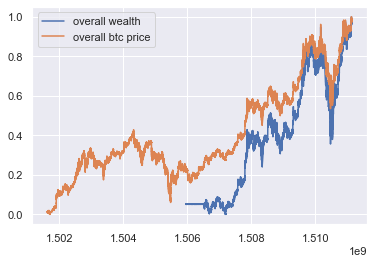

In [38]:
#buy when above, sell when below
#golden cross (50 day crosses above 200 day, bearish to bullish) vs death cross 

start = int(3.004 * 10**6 + 0*len(day))
end = start + 60*len(day)
rank = 50
time_delta = 1440 #1, 60, 1440 for minutes, hours, days, respectively

#end = 4857376 # TOGGLE for all data
#start = 0 + time_delta*rank # TOGGLE for all data

cash, coin, buy, sell, arr_index = (1000,0,0,0,0) # TOGGLE starting cash/coin values
starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash

prev_avg, nan_offset = calc_mov_avg(rank, time_delta, start) #pre-processing
prev_price = get_curr_price(start-1)

sample_rate = 1
arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

btc_value_dollars = [float] * arr_len
cash_value_dollars = [float] * arr_len
overall_wealth = [float] * arr_len

buy_proportion = 1
sell_proportion = 1
arr_index = 0

for i in range(start, end):
    
    mov_avg, nan_offset = efficient_mov_avg(prev_avg, rank, time_delta, i, nan_offset)
    curr_price = get_curr_price(i)
    
    if curr_price > mov_avg and prev_price < mov_avg: #handles NaN
        buy+=1
        cash,coin,success = execute_buy(curr_price, cash, coin, buy_proportion)

    elif curr_price < mov_avg and prev_price > mov_avg: #handles NaN
        sell+=1
        cash,coin,success = execute_sell(curr_price, cash, coin, sell_proportion)

    if (i-start) % sample_rate == 0:
        btc_value_dollars[arr_index] = coin * curr_price
        cash_value_dollars[arr_index] = cash
        overall_wealth[arr_index] = btc_value_dollars[arr_index] + cash
        arr_index+=1
        
    prev_price = curr_price
    prev_avg = mov_avg 
        
list_assets(starting_wealth, cash, coin, end)
display_data(overall_wealth, btc_value_dollars, cash_value_dollars, sample_rate, start, end, rank, time_delta)

# Percentage Trigger Trading Simulation

trade prop = 1.0: (trigger = 0.01, profit = -5.218%)
trade prop = 1.0: (trigger = 0.02, profit = -4.2444%)
trade prop = 1.0: (trigger = 0.03, profit = -3.1226%)
trade prop = 1.0: (trigger = 0.04, profit = -2.2834%)
trade prop = 1.0: (trigger = 0.05, profit = 16.4842%)
 


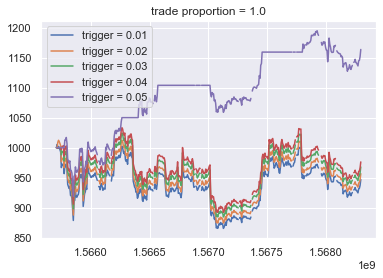

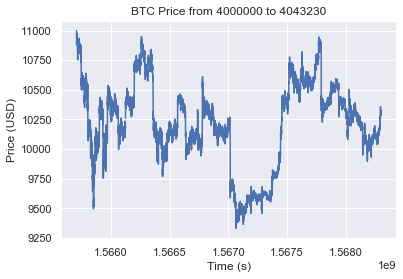

In [34]:
#simple buying and selling when percentage threshold is met

#print(f'{cash},{coin}') # for debugging
#print(f'{curr_price} buy')

def calc_thresholds(index, trigger_threshold):
    reference_price = get_curr_price(index)
    sell = (1 + trigger_threshold) * reference_price
    buy = (1 - trigger_threshold) * reference_price
    return (reference_price, sell, buy)
    
start = int(4 * 10**6 + 0*len(day)) # TOGGLE for start of time period
end = start + 30*len(day) # TOGGLE for end of time period

#end = 4857376 # TOGGLE for all data
#start = 0 # TOGGLE for all data

sample_rate = 100
arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

btc_value_dollars = [float] * arr_len
cash_value_dollars = [float] * arr_len
overall_wealth = [float] * arr_len


buy_proportions = [el/10 for el in range(10,11)] # TOGGLE this range to allow for trading w/ different trading proportions

trigger_thresholds = [el/100 for el in range(1,6)] # TOGGLE this range to allow for different percentage triggers
deltas = [float] * len(trigger_thresholds) # holds percentage changes of portfolio value
deltas_index = 0
figure = 0

for buy_prop in buy_proportions:
    
    deltas_index = 0
    plt.figure(figure)
    plt.title(f'trade proportion = {buy_prop}')
    
    for trigger_threshold in trigger_thresholds:
        
        cash, coin, buy, sell, arr_index = (1000,0,0,0,0) # TOGGLE starting cash/coin values
        starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash
        
        reference_price, sell_threshold, buy_threshold = calc_thresholds(start-1, trigger_threshold)
        #print(f'ref price: {reference_price}')
        for i in range(start, end):
            
            curr_price = get_curr_price(i)

            if curr_price >= sell_threshold: #handles NaN
                buy+=1
                cash, coin, succcess = execute_sell(curr_price, cash, coin, buy_prop)
                if success:
                    reference_price, sell_threshold, buy_threshold = calc_thresholds(i, trigger_threshold)
                    
            elif curr_price <= buy_threshold: #handles NaN
                sell+=1
                cash, coin, success = execute_buy(curr_price, cash, coin, buy_prop)
                if success:
                    reference_price, sell_threshold, buy_threshold = calc_thresholds(i, trigger_threshold)
                    
            if (i-start) % sample_rate == 0:
                btc_value_dollars[arr_index] = coin * curr_price
                cash_value_dollars[arr_index] = cash
                overall_wealth[arr_index] = btc_value_dollars[arr_index] + cash
                arr_index+=1
                
        plt.plot(df['Timestamp'][start:end:sample_rate],overall_wealth, label=f'trigger = {trigger_threshold}') # uncomment to graph different trigger thresholds
        deltas[deltas_index] = list_assets(starting_wealth, cash, coin, end, output=False)
        deltas_index+=1

    plt.legend(loc='best')
   
    for i in range(len(trigger_thresholds)):   
        print(f'trade prop = {buy_prop}: (trigger = {trigger_thresholds[i]}, profit = {round(deltas[i],4)}%)')
    print(' ')
    figure+=1
    
display_price_over_time_period(figure, start, end)

# Various Trading Simulations Utilizing Bollinger Bands + Visualization

Strategy 1 Results: 

cash: 1131.8305375026873
coin: 0.0 
total value: 1131.8305375026873
percent change: 13.183053750268733 

Strategy 2 Results: 

cash: 1144.5889330281009
coin: 0.0 
total value: 1144.5889330281009
percent change: 14.458893302810088 



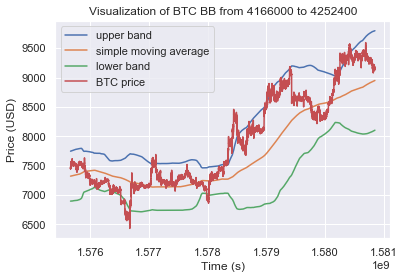

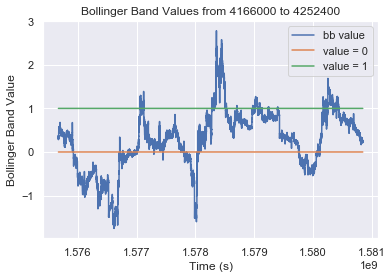

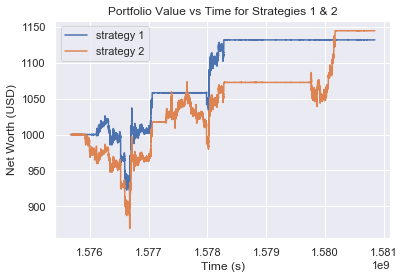

In [91]:
#price < low band: buying position 
#price > high band: selling position

sd_map = {
    10:1.5,
    14:2,
    20:2,
    50:2.5,
}

start = int(4.166 * 10**6 + 0*len(day)) # good demonstration day

#start = int(3.5 * 10**6)
end = start + int(60*minutes_in_day) # across two months

#end = 4857376 # TOGGLE for all data
Estart = 0 + time_delta*rank # TOGGLE for all data

rank = 14
time_delta = 1440 # TOGGLE 1, 60, 1440 for minutes, hours, days, respectively
time_interval = end-start

prev_avg, nan_offset = calc_mov_avg(rank, time_delta, start) #preprocessing
prev_price = get_curr_price(start-1)

sample_rate = 1
trade_prop = 1

arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

upper_band = [float] * arr_len
moving_avg = [float] * arr_len
lower_band = [float] * arr_len
bb_values = [float] * arr_len
overall_wealth_1 = [float] * arr_len
overall_wealth_2 = [float] * arr_len


arr_index = 0

# for first algo
cash_1, coin_1, buy_1, sell_1 = (1000,0,0,0) # TOGGLE starting cash/coin values
starting_wealth_1 = cash_1 + coin_1 * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash_1

# for second algo
cash_2, coin_2, buy_2, sell_2 = (1000,0,0,0) # TOGGLE starting cash/coin values
starting_wealth_2 = cash_2 + coin_2 * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash_2


for i in range(start, end):
    
    mov_avg, nan_offset = efficient_mov_avg(prev_avg, rank, time_delta, i, nan_offset)
    curr_price = get_curr_price(i)
    
    if (i-start) % sample_rate == 0:
        
        sd = calc_sd(rank, time_delta, i)[0]
        upper_band[arr_index] = mov_avg + (sd * sd_map[rank])
        moving_avg[arr_index] = mov_avg
        lower_band[arr_index] = mov_avg - (sd * sd_map[rank])
        bb_values[arr_index] = (curr_price - mov_avg) / (sd * sd_map[rank])

        #strategy 1
        if curr_price >= upper_band[arr_index] and prev_price < upper_band[arr_index]: #sell on upper band
            cash_1, coin_1, succcess_1 = execute_sell(curr_price, cash_1, coin_1, trade_prop)

        elif curr_price <= lower_band[arr_index] and prev_price > lower_band[arr_index]: #buy on lower band
            cash_1, coin_1, succcess_1 = execute_buy(curr_price, cash_1, coin_1, trade_prop)

        #strategy 2
        if bb_values[arr_index] >= 1: #sell on >= 1
            cash_2, coin_2, succcess_2 = execute_sell(curr_price, cash_2, coin_2, trade_prop)
 
        elif bb_values[arr_index] <= 0: #buy on <= 0
            cash_2, coin_2, succcess_2 = execute_buy(curr_price, cash_2, coin_2, trade_prop)
    
        
        overall_wealth_1[arr_index] = coin_1 * curr_price + cash_1
        overall_wealth_2[arr_index] = coin_2 * curr_price + cash_2
        arr_index+=1
        
    prev_avg = mov_avg
    prev_price = curr_price

print("Strategy 1 Results: \n")
res=list_assets(starting_wealth_1, cash_1, coin_1, end) 

print("Strategy 2 Results: \n")
res=list_assets(starting_wealth_2, cash_2, coin_2, end)

time_space = df['Timestamp'][start:end:sample_rate]

plt.figure(0)
plt.plot(time_space, upper_band, label='upper band')
plt.plot(time_space, moving_avg, label='simple moving average')
plt.plot(time_space, lower_band, label='lower band')
plt.plot(time_space, df['Weighted_Price'][start:end:sample_rate], label='BTC price')
plt.title(f'Visualization of BTC BB from {start} to {end}')
plt.xlabel('Time (s)')
plt.ylabel('Price (USD)')
plt.legend(loc='best')

plt.figure(1)
plt.plot(time_space, bb_values, label='bb value')
plt.plot(time_space, [0] * arr_len, label='value = 0')
plt.plot(time_space, [1] * arr_len, label='value = 1')
plt.title(f'Bollinger Band Values from {start} to {end}')
plt.xlabel('Time (s)')
plt.ylabel('Bollinger Band Value')
plt.legend(loc='best')

plt.figure(2)
plt.plot(time_space, overall_wealth_1, label='strategy 1')
plt.plot(time_space, overall_wealth_2, label='strategy 2')
plt.title('Portfolio Value vs Time for Strategies 1 & 2')
plt.xlabel('Time (s)')
plt.ylabel('Net Worth (USD)')
plt.legend(loc='best')

# Relative Strength Index Trading Strategy

cash: 8092618836887502.0
coin: 0.0 
total value: 8092618836887502.0
percent change: 809261883688650.2 



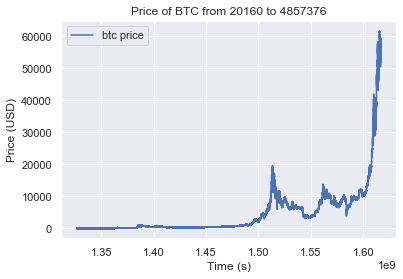

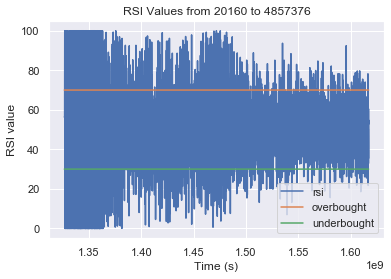

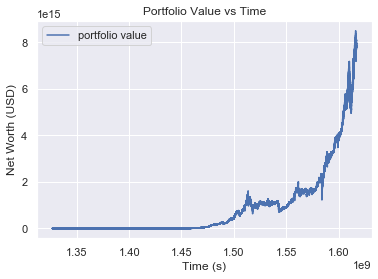

In [90]:
def calc_avg_gain_loss(start, rank, time_delta):
    gain = 0
    loss = 0
    
    for i in range(start-rank*time_delta, start):
        curr_price = get_curr_price(i)
        next_price = get_curr_price(i+1)
        delta = next_price - curr_price
        
        if delta > 0:
            gain+=delta
        elif delta < 0:
            loss+=abs(delta)
            
    avg_gain = gain / rank
    avg_loss = loss / rank 

    return (avg_gain, avg_loss)
        
start = 3 * 10**6
end = start + 60*minutes_in_day

end = 4857376 # TOGGLE for all data
start = 0 + time_delta*rank # TOGGLE for all data

cash, coin, buy, sell = (1000,0,0,0) # TOGGLE starting cash/coin values
starting_wealth = cash + coin * get_curr_price(start-1) if not np.isnan(get_curr_price(start-1)) else cash
        
    
rank = 14
smoothing_weight = rank-1

time_delta = 1440 # for days
sample_rate = 1
trade_prop = 1

overbought = 70
underbought = 30

arr_len = (int((end-start) / sample_rate)) if (end-start)%sample_rate == 0 else (int((end-start) / sample_rate)+1)

overall_wealth = [float] * arr_len
rsi_values = [float] * arr_len

prev_avg_gain, prev_avg_loss = calc_avg_gain_loss(start,rank,time_delta)
prev_price = get_curr_price(start-1)

for i in range(start,end):
    curr_price = get_curr_price(i)
    delta = curr_price - prev_price
    
    curr_gain = 0 
    curr_loss = 0

    if delta > 0: #increase from last price
        curr_gain = delta
    elif delta < 0: #decrease from last price
        curr_loss = abs(delta)
    
    avg_gain = (prev_avg_gain*smoothing_weight + curr_gain)/rank
    avg_loss = (prev_avg_loss*smoothing_weight + curr_loss)/rank
    relative_strength = avg_gain / avg_loss
    rsi_values[i-start] = 100 - (100 / (1 + relative_strength))
    
    if rsi_values[i-start] >= overbought:
        cash, coin, success = execute_sell(curr_price, cash, coin, trade_prop)
        
    elif rsi_values[i-start] <= underbought:
        cash, coin, success = execute_buy(curr_price, cash, coin, trade_prop)
        
    overall_wealth[i-start] = curr_price * coin + cash
    prev_avg_gain = avg_gain
    prev_avg_loss = avg_loss
    prev_price = curr_price

    
res = list_assets(starting_wealth, cash, coin, end)


time_span = df['Timestamp'][start:end]

plt.figure(0)
plt.plot(time_span[::sample_rate], df['Weighted_Price'][start:end:sample_rate], label='btc price')
plt.title(f'Price of BTC from {start} to {end}')
plt.ylabel('Price (USD)')
plt.xlabel('Time (s)')
plt.legend(loc='best')
    
plt.figure(1)  
step = 700 #plotted w/ large step value to make more visible, TOGGLE to 1 for full set of data
plt.plot(time_span[::step], rsi_values[::step], label='rsi') # rsi values
plt.plot(time_span, [overbought] * arr_len, label='overbought') # overbought marker
plt.plot(time_span, [underbought] * arr_len, label='underbought') # underbought marker
plt.title(f'RSI Values from {start} to {end}')
plt.ylabel('RSI Value')
plt.xlabel('Time (s)')
plt.legend(loc='best')
    
plt.figure(2)
plt.plot(time_span, overall_wealth, label='portfolio value')
plt.title('Portfolio Value vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Net Worth (USD)')
plt.legend(loc='best')   